# Zero-shot reference mapping tutorial with scGPT

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under `data` directory in the outer level.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y).


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Generate scGPT embeddings for each cell in reference and query datasets

 3. Transfer the annotations from reference to query dataset

At the [appendix](#appendix-reference-mapping-on-lung-kim-dataset) of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).


We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb)

In [3]:
pip uninstall torchvision

Found existing installation: torchvision 0.16.2
Uninstalling torchvision-0.16.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.16.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libz.0ba23de2.so.1
    /usr/local/lib/python3.10/dist-packages/torchvision/*
Proceed (Y/n)? n


In [4]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain faiss-cpu

    # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "covid")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS",
            output=os.path.join(data_dir),
        )
    if not os.path.exists(os.path.join(data_dir, "lung")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO",
            output=os.path.join(data_dir),
        )

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_human"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
            output=model_dir,
        )

Running on Google Colab
Installing dependencies...
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 

Retrieving folder contents


Retrieving folder 1A1H4VT1KaFkSoB5RqtkfM_gK0rrLhvYQ covid
Processing file 1727XIkbSol800zGe6xrnK9XcGDoCGchm batch_covid_subsampled_test.h5ad
Processing file 1xkNOBbHX2T3XCrrPqZngds5oGdWoEaB8 batch_covid_subsampled_train.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1727XIkbSol800zGe6xrnK9XcGDoCGchm
To: /data/covid/batch_covid_subsampled_test.h5ad
100%|██████████| 6.37M/6.37M [00:00<00:00, 97.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xkNOBbHX2T3XCrrPqZngds5oGdWoEaB8
To: /data/covid/batch_covid_subsampled_train.h5ad
100%|██████████| 19.0M/19.0M [00:00<00:00, 111MB/s] 
Download completed
Retrieving folder contents


Retrieving folder 1RyNAlTqdASuBQ2jKlsWC3rE07CI2n2Be lung
Processing file 1pptycRWjwqOb7XWvQQjdoRdzUrm8EMq- sample_proc_lung_test.h5ad
Processing file 1zMAwnjL0qyEjE4MAotanISCdWu13itNs sample_proc_lung_train.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1pptycRWjwqOb7XWvQQjdoRdzUrm8EMq-
To: /data/lung/sample_proc_lung_test.h5ad
100%|██████████| 15.4M/15.4M [00:00<00:00, 89.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zMAwnjL0qyEjE4MAotanISCdWu13itNs
To: /data/lung/sample_proc_lung_train.h5ad
100%|██████████| 60.5M/60.5M [00:00<00:00, 74.8MB/s]


Download completed
Retrieving folder contents


Processing file 1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1 args.json
Processing file 14AebJfGOUF047Eg40hk57HCtrb0fyDTm best_model.pt
Processing file 1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC vocab.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1
To: /save/scGPT_human/args.json
100%|██████████| 1.30k/1.30k [00:00<00:00, 4.32MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm
From (redirected): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm&confirm=t&uuid=82b9ff57-17d5-4a4e-83ff-6904add697ad
To: /save/scGPT_human/best_model.pt
100%|██████████| 205M/205M [00:01<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC
To: /save/scGPT_human/vocab.json
100%|██████████| 1.32M/1.32M [00:00<00:00, 132MB/s]
Download completed


## Import scGPT and dependencies

In [5]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back

Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [6]:
model_dir = Path("../../save/scGPT_human")
adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_train.h5ad')
test_adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_test.h5ad')

cell_type_key = "celltype"
gene_col = "gene_name"

Embed the reference dataset

In [7]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module(

Embed the query dataset

In [8]:
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 63/63 [00:08<00:00,  7.86it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


Mark the reference vs. query cells and mask the cell types on query cells

In [9]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

<ipython-input-9-e57926d27f57>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
<ipython-input-9-e57926d27f57>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensu

## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

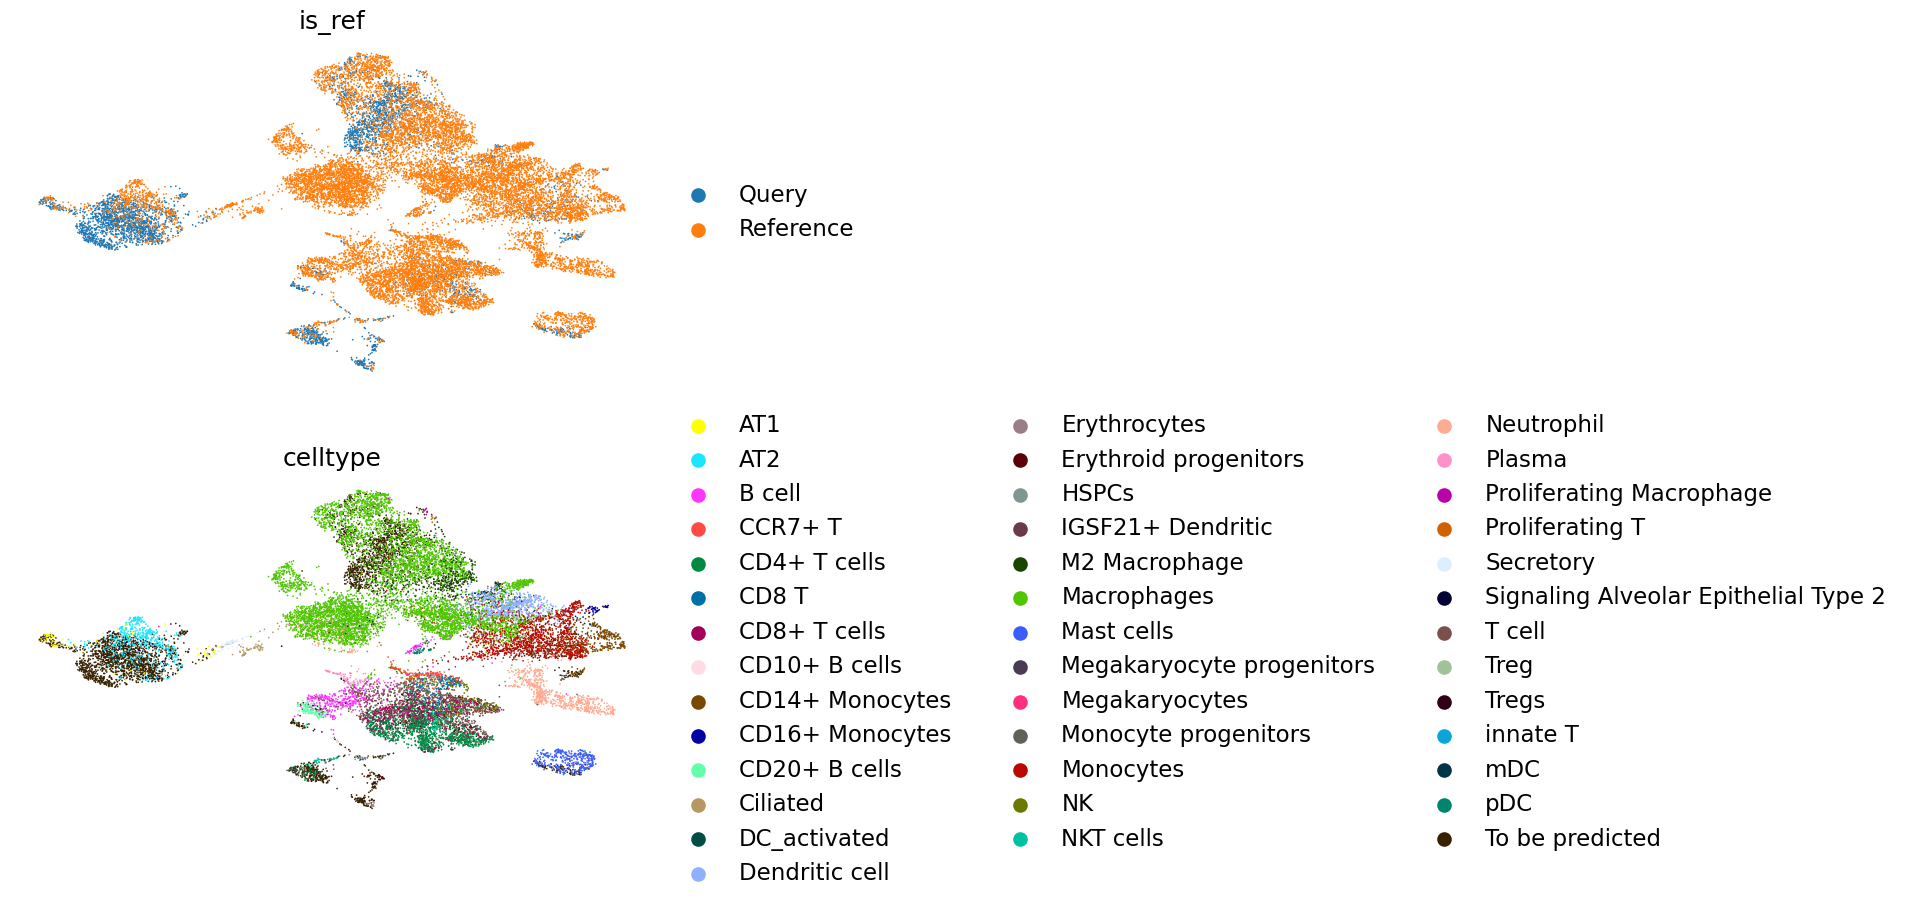

In [10]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [11]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)

        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [12]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()

流式输出内容被截断，只能显示最后 5000 行内容。
<ipython-input-12-19c2f745c566>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
<ipython-input-12-19c2f745c566>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
<ipython-input-12-19c2f745c566>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_ke

## Evaluate the performance

In [13]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.8785910567074694,
 'precision': 0.5269915473699017,
 'recall': 0.49150734826385345,
 'macro_f1': 0.4821051906274127}

Confusion matrix:

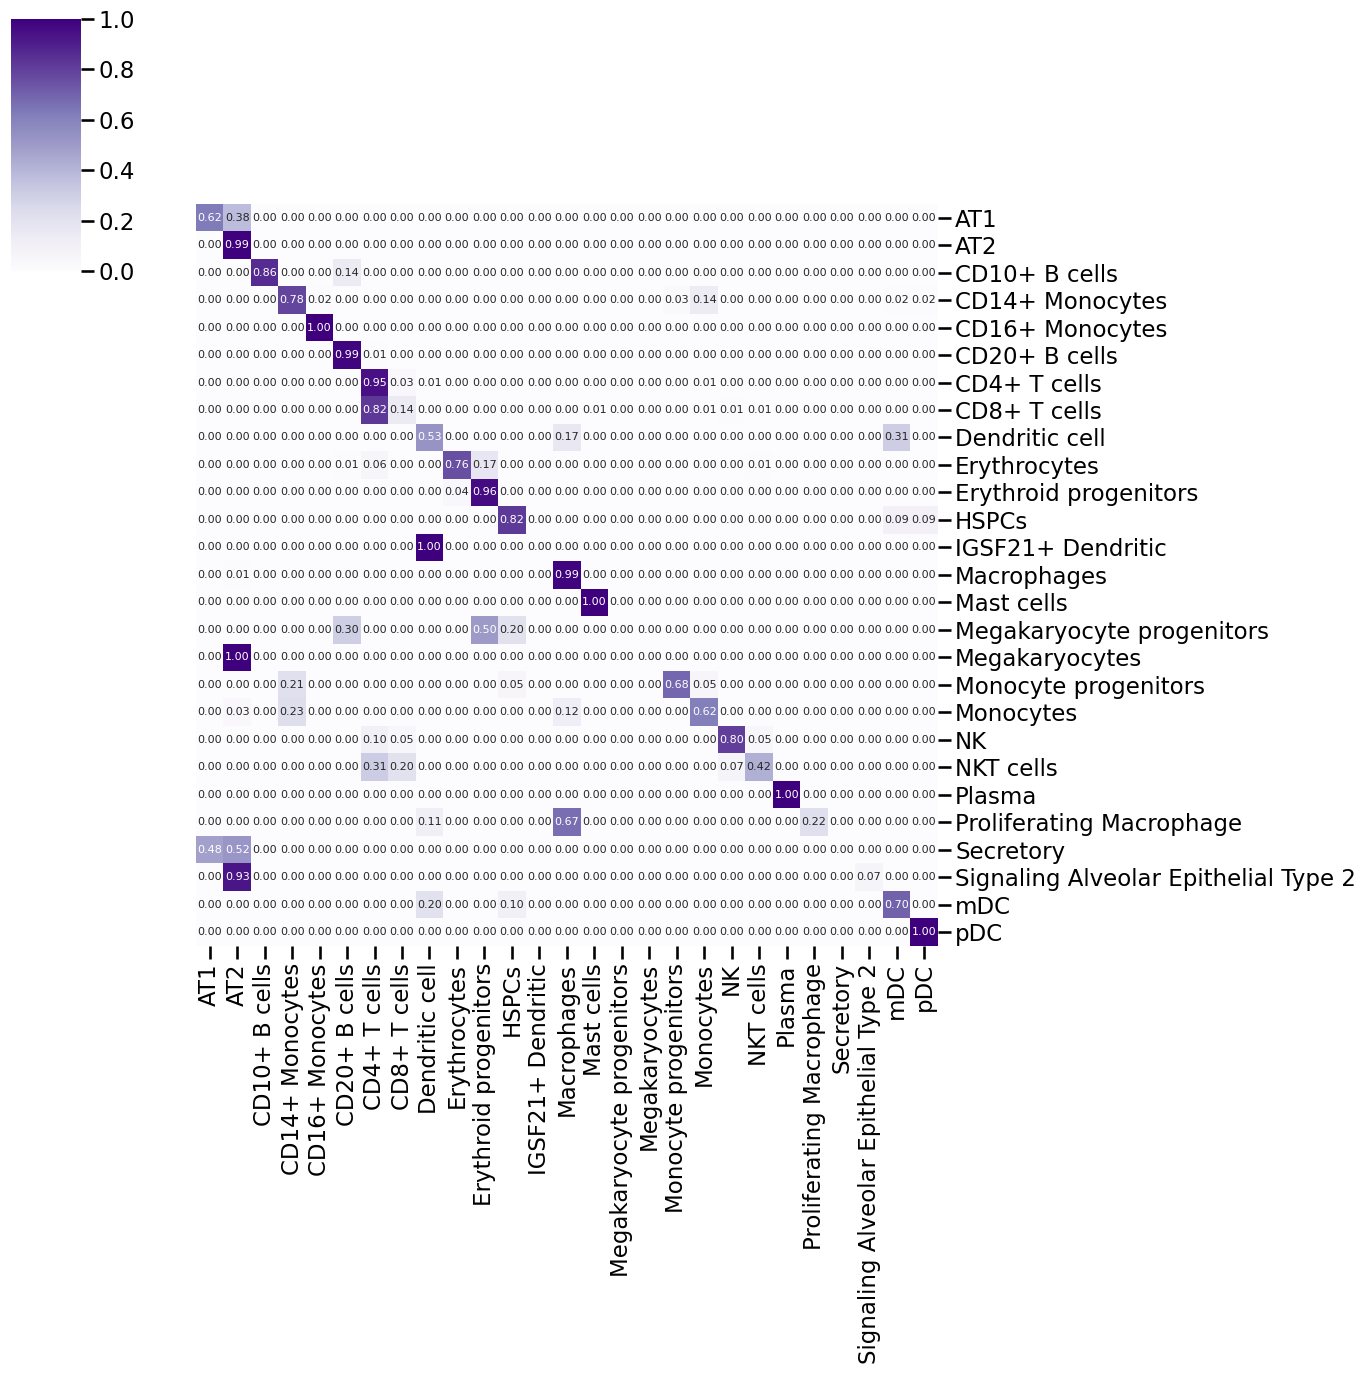

In [14]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,
                    cmap='Purples',
                    annot=True ,fmt=".2f",
                    annot_kws={'size': 8},
                    vmin=0,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    figsize=(14, 14))

## Appendix: Reference mapping on Lung-Kim dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).

In [15]:
adata = sc.read_h5ad('../../data/lung/sample_proc_lung_train.h5ad')
test_adata = sc.read_h5ad('../../data/lung/sample_proc_lung_test.h5ad')

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)

gene_col = "gene_name"
cell_type_key = "cell_type"

In [16]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

scGPT - INFO - match 2978/3000 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 363/363 [03:00<00:00,  2.01it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


scGPT - INFO - match 2978/3000 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 114/114 [00:54<00:00,  2.10it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
<ipython-input-16-873b3e99f3fc>:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
<ipython-input-16-873b3e99f3fc>:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You

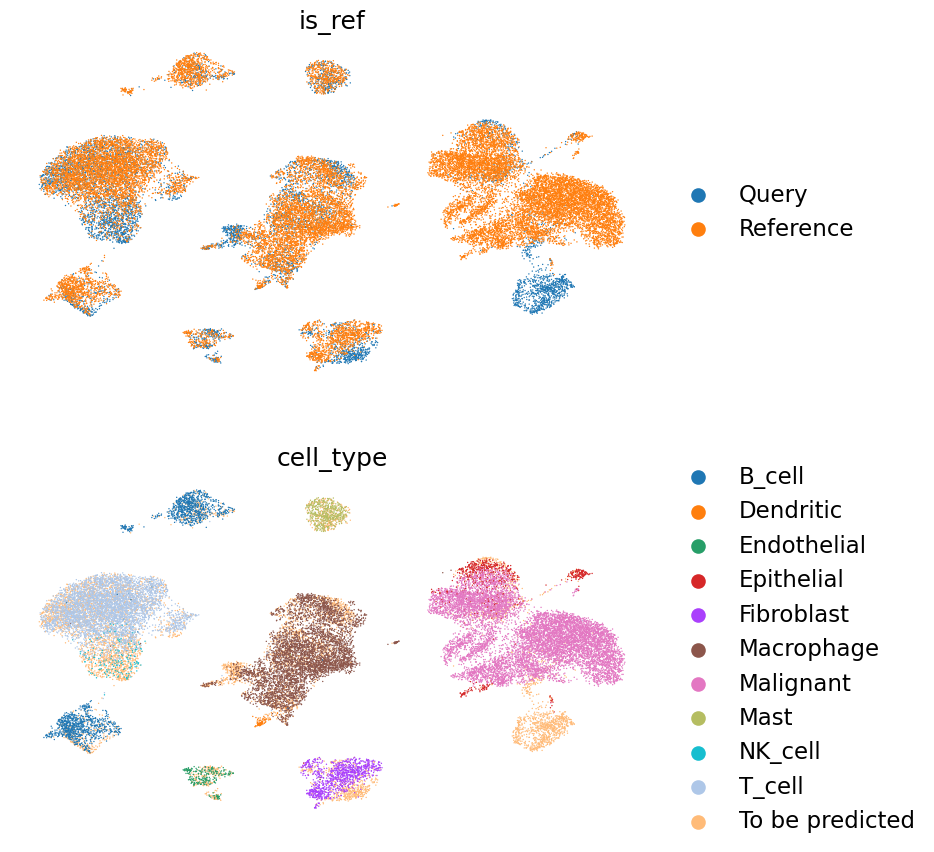

In [ ]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [17]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()

流式输出内容被截断，只能显示最后 5000 行内容。
<ipython-input-17-899501156cf5>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
<ipython-input-17-899501156cf5>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
<ipython-input-17-899501156cf5>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_ke

In [18]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.9681624811307808,
 'precision': 0.9631382153043017,
 'recall': 0.9488838854124705,
 'macro_f1': 0.9547517561241003}

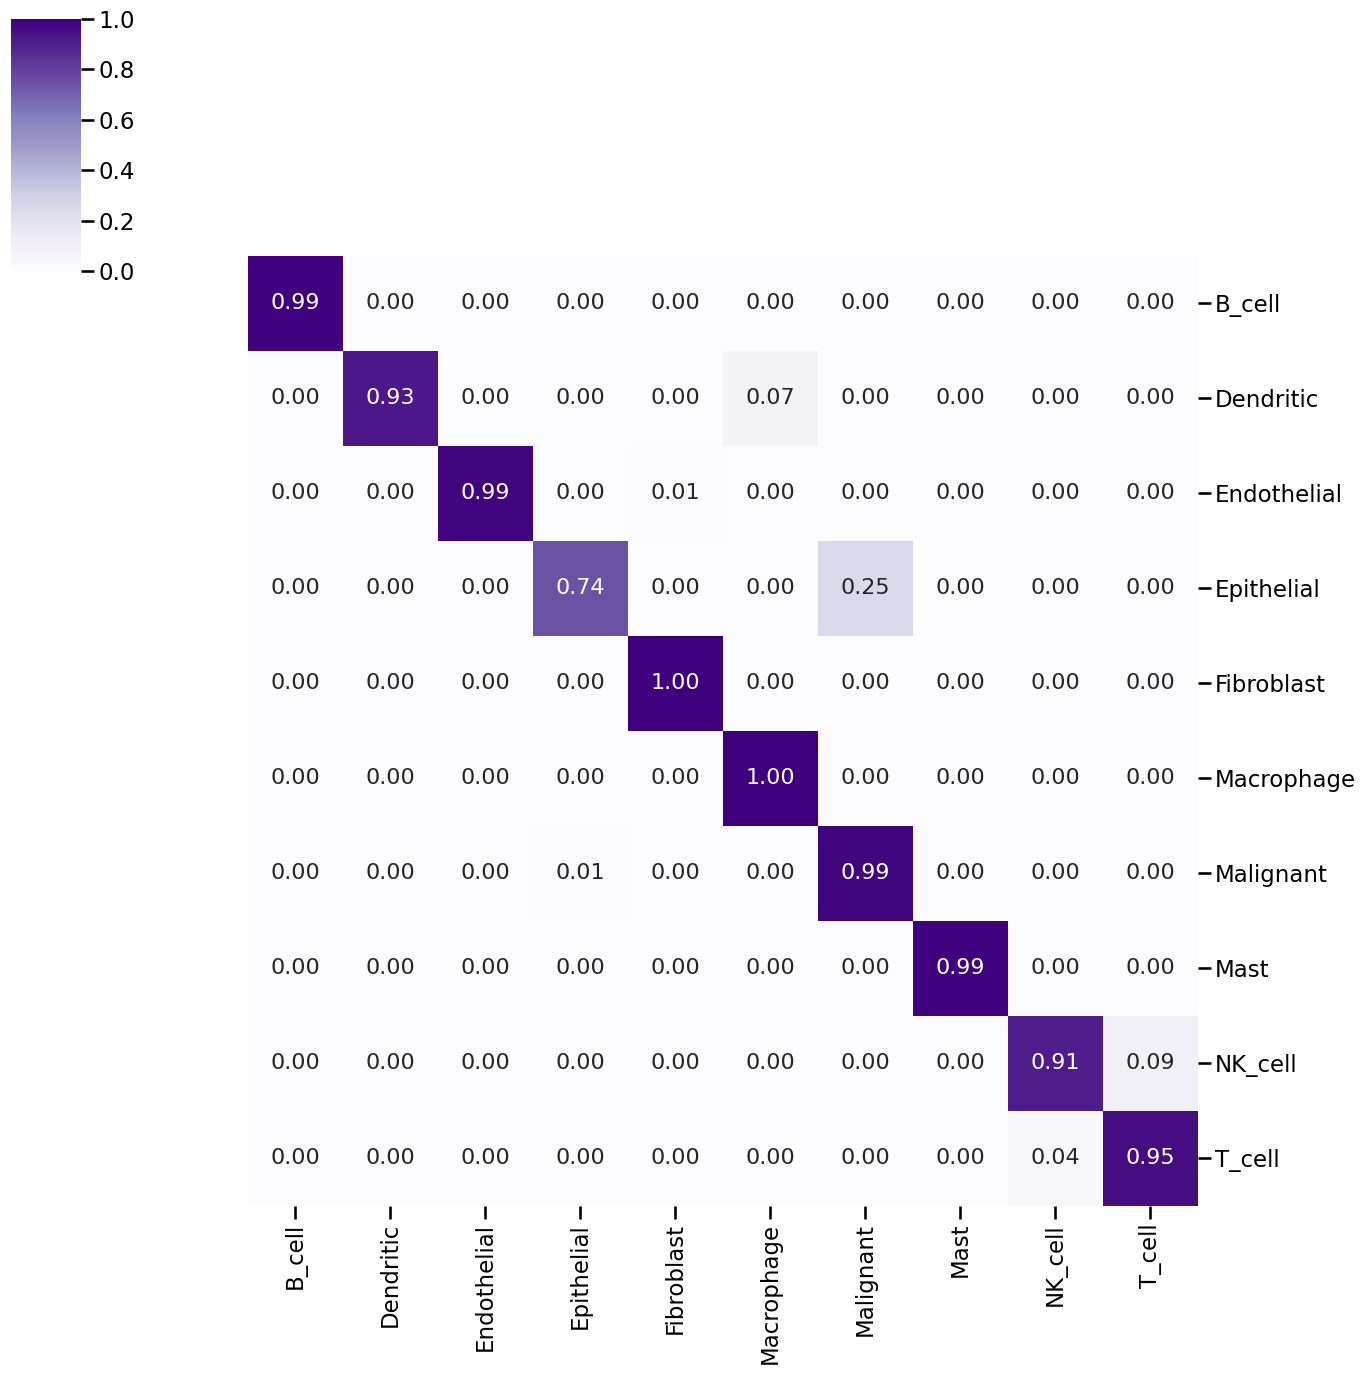

In [19]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,
                    cmap='Purples',
                    annot=True ,
                    fmt=".2f",
                    annot_kws={'size': 16},
                    vmin=0,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    figsize=(14, 14))